# **NHL Skating Video Analysis**

## **1: Setup & Import** <a id="functions"></a>

In [36]:
# verify the python version being used is from hockey_ai virtual environment
!which python

/Users/liammckendry/Project3_NHL_Videos/venv310/bin/python


In [35]:
import os  # OS library for interacting with the operating system

import numpy as np  # NumPy library for numerical operations
import pandas as pd # Pandas library for data manipulation
import math  # Math library for mathematical functions

from pytube import YouTube  # PyTube library for downloading YouTube videos
import yt_dlp  # yt-dlp library for downloading videos from various platforms
import cv2  # OpenCV library for computer vision tasks
import mediapipe as mp  # MediaPipe library for machine learning solutions

import matplotlib.pyplot as plt  # Matplotlib library for data visualization
import seaborn as sns  # Seaborn library for data visualization


## **2: Functions** <a id="functions"></a>

### **2.1 Utility Functions** <a id="utility"></a>

In [ ]:
# Function to monitor memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")


In [ ]:
def list_variables():
    """
    Print a detailed list of all variables in the current namespace.
    """
    get_ipython().magic('whos')

In [ ]:
def delete_variables(*args):
    """
    Delete all variables or specific variables provided in arguments, and clear garbage.
    
    Parameters:
    *args: List of variable names to delete. If no arguments are provided, all variables will be deleted.
    """
    
    ipython = get_ipython()
    
    if args:
        for var in args:
            if var in ipython.user_ns:
                del ipython.user_ns[var]
                print(f"Deleted variable: {var}")
            else:
                print(f"Variable not found: {var}")
    else:
        ipython.magic('reset -f')
        print("Deleted all variables.")
    
    gc.collect()
    print("Garbage collection complete.")

In [ ]:
# function get a list of functions defined in notebook
def printFunctions():
    functions_list = [name for name, obj in globals().items() if callable(obj) and obj.__module__ == '__main__']
    print("📌 Functions Defined in Notebook:")
    print("\n".join(functions_list))

In [ ]:
# Function to check dataset structure and print first 5 rows
def checkDataset(df):
    df.info()
    df.head()

In [ ]:
#Function to print API response in a readable dictionary so we can investigate the structure
def read_APIResponseStructure(url):
    
    # Fetch game data
    response = requests.get(url)
    data = response.json()

    pp = pprint.PrettyPrinter(depth=4)  # Limits deep nesting
    pp.pprint(data)

In [ ]:
# Monitor DataFrame Memory Usage

def show_memory_usage():
    """Displays memory usage of all DataFrames in global scope."""
    for var_name in list(globals()):
        var_value = globals()[var_name]
        if isinstance(var_value, (pd.DataFrame, pd.Series)):  # Check if it's a DataFrame
            print(f"{var_name}: {sys.getsizeof(var_value) / (1024 * 1024):.2f} MB")

show_memory_usage()  # Run this after loading data

In [ ]:
# Delete Large DataFrames When No Longer Needed

def delete_dataframe(df):
    del df
    gc.collect()  # Force garbage collection


In [ ]:
# Optimize DataFrame Column Types (from 64->32 float or int vars)

def optimize_dataframe(df):
    """Reduce memory usage by downcasting numerical columns."""
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')
    return df


In [ ]:
# remove hidden variables that are taking up memory

def remove_hidden_variables():
    %reset out -f


### **2.2 Video Functions** <a id="video"></a>

In [37]:
def process_videos(url_list, output_dir, frame_interval, metrics, csv_output_path):
    """
    Process a list of YouTube video URLs: download, extract frames, get pose landmarks, and calculate metrics.

    Parameters:
    url_list (list): List of YouTube video URLs.
    output_dir (str): Directory to save downloaded videos and frames.
    frame_interval (int): Interval of frames to save (e.g., save every k-th frame).
    metrics (list): List of metrics to calculate.
    csv_output_path (str): Path to save the calculated metrics CSV file.
    """
    for i, youtube_url in enumerate(url_list):
        try:
            print(f"Processing video {i+1}/{len(url_list)}: {youtube_url}")

            # Step 1: Download the video
            video_output_path = os.path.join(output_dir, f"video_{i+1}.mp4")
            download_video(youtube_url, video_output_path)

            # Step 2: Retrieve and print video properties
            duration, total_frames, fps = get_video_properties(video_output_path)
            print(f"Video Length: {duration:.2f} seconds, Total Frames: {total_frames}, FPS: {fps}")

            # Step 3: Extract and save frames
            frame_folder_path = os.path.join(output_dir, f"frames_{i+1}")
            extract_and_save_frames(video_output_path, frame_folder_path, frame_interval)

            # Step 4: Get and draw pose landmarks
            pose_folder_path = os.path.join(output_dir, f"pose_output_{i+1}")
            pose_estimates = get_pose_landmarks(frame_folder_path)
            draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path)

            # Step 5: Calculate pose metrics and save to CSV
            frame_time = 1 / fps
            df_metrics = calculate_metrics(pose_estimates, frame_time, metrics)
            csv_path = os.path.join(output_dir, f"metrics_{i+1}.csv")
            save_to_csv(df_metrics, csv_path)

            print(f"Processing complete for video {i+1}/{len(url_list)}")

        except Exception as e:
            print(f"An error occurred while processing video {i+1}/{len(url_list)}: {e}")

In [ ]:
def download_video(youtube_url, output_path):
    """
    Download a video from YouTube using yt-dlp.

    Parameters:
    youtube_url (str): URL of the YouTube video to download.
    output_path (str): Path to save the downloaded video.
    """
    # Define options for yt-dlp
    ydl_opts = {
        "format": "bestvideo+bestaudio/best",  # Download the best video and audio quality available
        "merge_output_format": "mp4",  # Ensure video and audio are merged into an MP4 file
        "outtmpl": output_path,  # Set the output file path
        "ffmpeg_location": "/opt/homebrew/bin/ffmpeg"  # Specify the location of the ffmpeg executable
    }

    try:
        # Create a YoutubeDL object with the specified options
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            # Download the video from the provided URL
            ydl.download([youtube_url])
        print("Video downloaded successfully!")
    except Exception as e:
        # Print an error message if an exception occurs
        print(f"An error occurred: {e}")


[youtube] Extracting URL: https://www.youtube.com/watch?v=y0wIRVQDbJc
[youtube] y0wIRVQDbJc: Downloading webpage
[youtube] y0wIRVQDbJc: Downloading tv client config
[youtube] y0wIRVQDbJc: Downloading player f6e09c70
[youtube] y0wIRVQDbJc: Downloading tv player API JSON
[youtube] y0wIRVQDbJc: Downloading ios player API JSON
[youtube] y0wIRVQDbJc: Downloading m3u8 information
[info] y0wIRVQDbJc: Downloading 1 format(s): 137+251
[download] ../data/temp_video_2.mp4 has already been downloaded


ERROR: Unable to download video: [Errno 2] No such file or directory


An error occurred: ERROR: Unable to download video: [Errno 2] No such file or directory


In [ ]:
def get_video_properties(video_path):
    """
    Get the video length, total number of frames, and frames per second (FPS).

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    tuple: A tuple containing video length (float), total number of frames (int), and frames per second (float).
    """
    # Open the video file using OpenCV (cv2) library
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
    duration = frame_count_total / fps  # Duration in seconds

    return duration, frame_count_total, fps


Video Length: 11.64 seconds
Total Frames: 349


In [ ]:
def extract_and_save_frames(video_path, frame_folder_path, k):
    """
    Extract and save every k-th frame from a video.

    Parameters:
    video_path (str): Path to the video file.
    frame_folder_path (str): Path to the folder where frames will be saved.
    k (int): Interval of frames to save (e.g., save every k-th frame).
    """
    # Create folder for video frames if it doesn't exist
    os.makedirs(frame_folder_path, exist_ok=True)

    # Open the video file using OpenCV (cv2) library
    cap = cv2.VideoCapture(video_path)
    frame_count = 0  # Initialize frame count

    while cap.isOpened():  # Loop until the video is opened
        ret, frame = cap.read()  # Read a frame from the video
        if not ret:  # If no frame is returned, break the loop
            break

        # Save every k-th frame
        if frame_count % k == 0:  # Check if the frame count is a multiple of k
            frame_filename = f"{frame_folder_path}/frame_{frame_count}.jpg"  # Create a filename for the frame
            if not os.path.exists(frame_filename):  # Check if the frame file already exists
                cv2.imwrite(frame_filename, frame)  # Save the frame as an image
            else:
                print(f"Skipping {frame_filename}, already exists.")

        frame_count += 1  # Increment the frame count

    cap.release()  # Release the video capture object
    print("Frames extracted successfully!")  # Print success message



Frames extracted successfully!


In [ ]:
def get_pose_landmarks(frame_folder_path):
    """
    Return an array of pose landmarks for each frame.

    Parameters:
    frame_folder_path (str): Path to the folder containing video frames.

    Returns:
    list: A list of tuples containing frame name and pose landmarks.
    """
    # Initialize MediaPipe Pose solution
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    
    # List to store pose estimates
    pose_estimates = []

    # Iterate over each frame in the folder
    for frame_name in os.listdir(frame_folder_path):
        frame_path = os.path.join(frame_folder_path, frame_name)
        
        # Skip files that do not have valid image extensions
        if not frame_name.lower().endswith(VALID_EXTENSIONS):
            continue

        # Read the frame image
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        # Convert the image from BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the image to get pose landmarks
        results = pose.process(rgb_frame)
        
        # If pose landmarks are detected, append them to the list
        if results.pose_landmarks:
            pose_estimates.append((frame_name, results.pose_landmarks))

    return pose_estimates

In [38]:
def draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path):
    """
    Create drawings of pose landmarks on each frame and store images in a new folder.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.
    frame_folder_path (str): Path to the folder containing video frames.
    pose_folder_path (str): Path to the folder to save frames with pose landmarks.
    """
    mp_drawing = mp.solutions.drawing_utils  # MediaPipe drawing utilities for drawing landmarks
    os.makedirs(pose_folder_path, exist_ok=True)  # Create the output folder if it doesn't exist

    for frame_name, pose_landmarks in pose_estimates:
        frame_path = os.path.join(frame_folder_path, frame_name)  # Path to the original frame
        output_path = os.path.join(pose_folder_path, frame_name.replace(".jpg", "_landmark.jpg"))  # Path to save the frame with landmarks
        
        if os.path.exists(output_path):  # Skip processing if the output file already exists
            print(f"Skipping {output_path}, already exists.")
            continue

        frame = cv2.imread(frame_path)  # Read the frame image
        if frame is None:  # Skip if the frame could not be read
            continue

        mp_drawing.draw_landmarks(frame, pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)  # Draw pose landmarks on the frame
        cv2.imwrite(output_path, frame)  # Save the frame with landmarks to the output path


In [ ]:
def count_frames_with_landmarks(pose_estimates):
    """
    Return the number of frames with pose landmarks.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.

    Returns:
    int: The number of frames with pose landmarks.
    """
    return len(pose_estimates)

In [ ]:
# analyze skating metrics - measure knee bend angle

def calculate_angle(a, b, c):
    """
    Calculate angle between three points (a, b, c).
    a, b, c are tuples of (x, y) coordinates.
    """
    # Vector from point a to point b
    ab = np.array([a[0] - b[0], a[1] - b[1]])
    # Vector from point c to point b
    bc = np.array([c[0] - b[0], c[1] - b[1]])

    # Calculate the cosine of the angle using dot product and magnitudes of vectors
    cosine_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    # Calculate the angle in degrees
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

# Example usage:
# Define points a, b, and c as tuples of (x, y) coordinates
a = (0.5, 0.5)
b = (0.5, 0.6)
c = (0.6, 0.6)

# Calculate the angle between points a, b, and c
angle = calculate_angle(a, b, c)
print(f"The angle between points a, b, and c is {angle:.2f} degrees.")

In [ ]:
def calculate_knee_angles(pose_estimates):
    """
    Calculate knee angles for a set of frame pose estimates.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.

    Returns:
    list: A list of tuples containing frame name and knee angle.
    """
    knee_angles = []  # Initialize an empty list to store knee angles
    for frame_name, pose_estimate in pose_estimates:  # Iterate over each frame and its pose estimate
        # Extract landmarks for hip, knee, and ankle
        landmarks = pose_estimate.landmark  # Get the landmarks from the pose estimate
        hip = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)  # Get hip coordinates
        knee = (landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y)  # Get knee coordinates
        ankle = (landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y)  # Get ankle coordinates
        
        # Calculate knee bend angle
        knee_angle = calculate_angle(hip, knee, ankle)  # Calculate the angle between hip, knee, and ankle
        knee_angles.append((frame_name, knee_angle))  # Append the frame name and knee angle to the list
    return knee_angles  # Return the list of knee angles

In [ ]:
def get_landmarks(pose_estimates, *landmark_names):
    """
    Return specified landmarks for a set of frame pose estimates.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.
    *landmark_names (str): Names of landmarks to extract (e.g., 'left_hip', 'right_hip').

    Returns:
    list: A list of dictionaries containing frame name and specified landmarks.
    """
    # Define a dictionary to map landmark names to their corresponding indices in the pose landmarks
    landmark_indices = {
        'left_hip': mp_pose.PoseLandmark.LEFT_HIP,
        'right_hip': mp_pose.PoseLandmark.RIGHT_HIP,
        'left_knee': mp_pose.PoseLandmark.LEFT_KNEE,
        'right_knee': mp_pose.PoseLandmark.RIGHT_KNEE,
        'left_ankle': mp_pose.PoseLandmark.LEFT_ANKLE,
        'right_ankle': mp_pose.PoseLandmark.RIGHT_ANKLE,
        'left_shoulder': mp_pose.PoseLandmark.LEFT_SHOULDER,
        'right_shoulder': mp_pose.PoseLandmark.RIGHT_SHOULDER,
        'left_elbow': mp_pose.PoseLandmark.LEFT_ELBOW,
        'right_elbow': mp_pose.PoseLandmark.RIGHT_ELBOW,
        'left_wrist': mp_pose.PoseLandmark.LEFT_WRIST,
        'right_wrist': mp_pose.PoseLandmark.RIGHT_WRIST,
        'left_eye': mp_pose.PoseLandmark.LEFT_EYE,
        'right_eye': mp_pose.PoseLandmark.RIGHT_EYE,
        'nose': mp_pose.PoseLandmark.NOSE,
        'left_ear': mp_pose.PoseLandmark.LEFT_EAR,
        'right_ear': mp_pose.PoseLandmark.RIGHT_EAR,
        'mouth_left': mp_pose.PoseLandmark.MOUTH_LEFT,
        'mouth_right': mp_pose.PoseLandmark.MOUTH_RIGHT,
        'left_pinky': mp_pose.PoseLandmark.LEFT_PINKY,
        'right_pinky': mp_pose.PoseLandmark.RIGHT_PINKY,
        'left_index': mp_pose.PoseLandmark.LEFT_INDEX,
        'right_index': mp_pose.PoseLandmark.RIGHT_INDEX,
        'left_thumb': mp_pose.PoseLandmark.LEFT_THUMB,
        'right_thumb': mp_pose.PoseLandmark.RIGHT_THUMB,
        'left_foot_index': mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
        'right_foot_index': mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
        'left_heel': mp_pose.PoseLandmark.LEFT_HEEL,
        'right_heel': mp_pose.PoseLandmark.RIGHT_HEEL,
        'left_big_toe': mp_pose.PoseLandmark.LEFT_BIG_TOE,
        'right_big_toe': mp_pose.PoseLandmark.RIGHT_BIG_TOE,
        'left_small_toe': mp_pose.PoseLandmark.LEFT_SMALL_TOE,
        'right_small_toe': mp_pose.PoseLandmark.RIGHT_SMALL_TOE
    }
    
    results = []  # Initialize an empty list to store the results
    for frame_name, pose_estimate in pose_estimates:  # Iterate over each frame and its pose estimate
        landmarks = pose_estimate.landmark  # Get the landmarks from the pose estimate
        frame_landmarks = {'frame_name': frame_name}  # Initialize a dictionary to store the frame name and landmarks
        for name in landmark_names:  # Iterate over the specified landmark names
            if name in landmark_indices:  # Check if the landmark name is in the dictionary
                landmark = landmarks[landmark_indices[name]]  # Get the landmark using its index
                frame_landmarks[name] = (landmark.x, landmark.y)  # Store the landmark coordinates in the dictionary
        results.append(frame_landmarks)  # Append the dictionary to the results list
    return results  # Return the list of dictionaries containing frame names and specified landmarks

In [ ]:
# Define function for calculating Euclidean distance (stride length)
def euclidean_distance(p1, p2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    p1 (tuple): The (x, y) coordinates of the first point.
    p2 (tuple): The (x, y) coordinates of the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Calculate the difference in x-coordinates and y-coordinates
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    # Calculate the Euclidean distance using the Pythagorean theorem
    distance = (dx**2 + dy**2) ** 0.5
    
    return distance

In [ ]:
# Function to calculate knee angle
def calculate_knee_angle(landmarks):
    """
    Calculate the knee angle based on the positions of the hip, knee, and ankle landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated knee angle in degrees.
    """
    # Extract x and y coordinates of the hip
    hip = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the knee
    knee = (landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y)
    
    # Extract x and y coordinates of the ankle
    ankle = (landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y)
    
    # Calculate the angle between the hip, knee, and ankle
    angle = calculate_angle(hip, knee, ankle)
    
    return angle


SyntaxError: unterminated string literal (detected at line 92) (2825493930.py, line 92)

In [ ]:
# Function to calculate stride length
def calculate_stride_length(landmarks):
    """
    Calculate the stride length based on the positions of the left and right ankles.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated stride length.
    """
    # Extract x and y coordinates of the left ankle
    left_foot = (landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y)
    
    # Extract x and y coordinates of the right ankle
    right_foot = (landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y)
    
    # Calculate the Euclidean distance between the left and right ankle positions
    stride_length = euclidean_distance(left_foot, right_foot)
    
    return stride_length

In [ ]:
# Function to calculate hip stability
def calculate_hip_stability(landmarks):
    """
    Calculate the stability of the hips based on the Euclidean distance between the left and right hip landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated hip stability.
    """
    # Extract x and y coordinates of the left hip
    left_hip = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the right hip
    right_hip = (landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y)
    
    # Calculate the Euclidean distance between the left and right hip positions
    hip_stability = euclidean_distance(left_hip, right_hip)
    
    return hip_stability

In [ ]:
# Function to calculate forward lean angle
def calculate_forward_lean(landmarks):
    """
    Calculate the forward lean angle based on shoulder, torso, and knee landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated forward lean angle in degrees.
    """
    # Extract x and y coordinates of the left shoulder
    shoulder = (landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y)
    
    # Extract x and y coordinates of the left hip (torso)
    torso = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the left knee
    knee = (landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y)
    
    # Calculate the angle between the shoulder, torso, and knee
    angle = calculate_angle(shoulder, torso, knee)
    
    # Print the calculated forward lean angle
    print(f'Forward lean angle: {angle}')
    
    return angle

In [ ]:
# Function to calculate stride cadence (steps per second)
def calculate_stride_cadence(pose_estimates, frame_time):
    """
    Calculate the stride cadence (steps per second) from pose estimates.

    Parameters:
    pose_estimates (list): List of tuples containing frame name and pose landmarks.
    frame_time (float): Time duration of each frame.

    Returns:
    float: Stride cadence (steps per second).
    """
    left_step_count, right_step_count = 0, 0  # Initialize step counts for left and right foot
    prev_left_foot, prev_right_foot = None, None  # Initialize previous positions of left and right foot

    for frame_name, pose_estimate in pose_estimates:
        landmarks = pose_estimate.landmark  # Extract landmarks from pose estimate
        left_foot = (landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y)  # Get left foot position
        right_foot = (landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y)  # Get right foot position

        if prev_left_foot is not None and prev_right_foot is not None:
            # Detect if a step has occurred for left and right foot
            left_step, right_step, _, _ = detect_stride_cadence(landmarks, prev_left_foot, prev_right_foot, frame_time)
            if left_step:
                left_step_count += 1  # Increment left step count if a step is detected
            if right_step:
                right_step_count += 1  # Increment right step count if a step is detected

        prev_left_foot, prev_right_foot = left_foot, right_foot  # Update previous foot positions

    total_steps = left_step_count + right_step_count  # Calculate total steps
    return total_steps / (len(pose_estimates) * frame_time)  # Calculate and return stride cadence (steps per second)

In [ ]:
# Function to calculate arm swing angle
def calculate_arm_swing(landmarks):
    """
    Calculate the arm swing angle based on shoulder and hip landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated arm swing angle in degrees.
    """
    # Extract x and y coordinates of the left shoulder
    left_shoulder = (landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y)
    
    # Extract x and y coordinates of the right shoulder
    right_shoulder = (landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y)
    
    # Extract x and y coordinates of the left hip (torso)
    torso = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)
    
    # Calculate the angle between the left shoulder, right shoulder, and torso
    return calculate_angle(left_shoulder, right_shoulder, torso)


In [ ]:
# Function to calculate glide length
def calculate_glide_length(hip_position):
    """
    Calculate the glide length based on the hip position.

    Parameters:
    hip_position (list or tuple): The (x, y) coordinates of the hip position.

    Returns:
    float: The calculated glide length.

    Raises:
    ValueError: If hip_position is not a non-empty list or tuple.
    """
    
    # Check if hip_position is a non-empty list or tuple
    if not isinstance(hip_position, (list, tuple)) or len(hip_position) == 0:
        raise ValueError("hip_position must be a non-empty list or tuple")
    
    # Warn if more than one element is provided, but only use the first element
    if len(hip_position) > 1:
        print("Warning: Only the first element will be used for glide length calculation.")
    
    # Calculate glide length based on the first element of hip_position
    # Explain calculation: If hip_position[0] is less than 0.5, the skater is on the left side of the rink
    # If hip_position[0] is greater than 0.5, the skater is on the right side of the rink
    # The glide length is the distance from the skater's position to the center of the
    # rink (0.5) or the opposite side (1 - 0.5 = 0.5)
    return hip_position[0] if hip_position[0] > 0.5 else 1 - hip_position[0]

In [ ]:
# Function to calculate glide time
def calculate_glide_time(distance, speed):
    """
    Calculate the glide time based on distance and speed.

    Parameters:
    distance (float): The distance covered during the glide.
    speed (float): The speed during the glide.

    Returns:
    float: The calculated glide time. If speed is zero, returns infinity to avoid division by zero.
    """
    if speed == 0:
        return float('inf')  # Return infinity if speed is zero to avoid division by zero
    return distance / speed  # Calculate glide time as distance divided by speed

In [ ]:
# Function to calculate glide ratio
def calculate_glide_ratio(glide_time, stride_time):
    """
    Calculate the glide ratio based on glide time and stride time.

    Parameters:
    glide_time (float): The time spent gliding.
    stride_time (float): The time spent striding.

    Returns:
    float: The calculated glide ratio. If stride_time is zero, returns 0 to avoid division by zero.
    """
    # Check if stride_time is greater than zero to avoid division by zero
    if stride_time > 0:
        return glide_time / stride_time
    else:
        return 0

In [ ]:
# Function to calculate glide symmetry
def calculate_glide_symmetry(left_hip_position, right_hip_position):
    """
    Calculate the glide symmetry based on the difference in glide lengths of the left and right hips.

    Parameters:
    left_hip_position (tuple): The (x, y) coordinates of the left hip.
    right_hip_position (tuple): The (x, y) coordinates of the right hip.

    Returns:
    float: The calculated glide symmetry.
    """
    # Calculate glide length for the left hip
    glide_length_left = calculate_glide_length(left_hip_position)
    
    # Calculate glide length for the right hip
    glide_length_right = calculate_glide_length(right_hip_position)
    
    # Calculate the absolute difference between the left and right glide lengths
    symmetry_value = abs(glide_length_left - glide_length_right)

    return symmetry_value

In [ ]:
# Function to calculate glide stability
def calculate_glide_stability(left_hip_position, right_hip_position):
    """
    Calculate the glide stability based on the Euclidean distance between the left and right hip positions.

    Parameters:
    left_hip_position (tuple): The (x, y) coordinates of the left hip.
    right_hip_position (tuple): The (x, y) coordinates of the right hip.

    Returns:
    float: The calculated glide stability.
    """
    # Calculate the Euclidean distance between the left and right hip positions
    stability = euclidean_distance(left_hip_position, right_hip_position)

    return stability

In [ ]:
# Function to calculate glide efficiency
def calculate_glide_efficiency(glide_length_left, glide_stability):
    """
    Calculate the glide efficiency based on glide length and stability.

    Parameters:
    glide_length_left (float): The glide length of the left hip.
    glide_stability (float): The stability of the glide.

    Returns:
    float: The calculated glide efficiency.

    Raises:
    ValueError: If glide_length_left or glide_stability is negative.
    """
    # Check if glide_length_left is non-negative
    if glide_length_left < 0:
        raise ValueError("glide_length_left must be non-negative")
    
    # Check if glide_stability is non-negative
    if glide_stability < 0:
        raise ValueError("glide_stability must be non-negative")
    
    # Calculate glide efficiency as the ratio of glide length to stability
    # If glide_stability is zero, return 0 to avoid division by zero
    return glide_length_left / glide_stability if glide_stability > 0 else 0

In [ ]:
# Function to get position (left_hip position as centre of mass)
def get_position(landmarks):
    """
    Get the position of the left hip from the pose landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    tuple: Position of the left hip as (x, y) coordinates.

    Raises:
    ValueError: If the landmark positions are negative.
    """
    # Extract x and y coordinates of the left hip
    left_hip_x = landmarks[mp_pose.PoseLandmark.LEFT_HIP].x
    left_hip_y = landmarks[mp_pose.PoseLandmark.LEFT_HIP].y
    
    # Check if the coordinates are non-negative
    if left_hip_x < 0 or left_hip_y < 0:
        raise ValueError("Landmark positions must be non-negative")

    # Print the left hip position for debugging
    print(f"Left Hip Position: x={left_hip_x}, y={left_hip_y}")
    
    # Return the position as a tuple
    return (left_hip_x, left_hip_y)

In [ ]:
# Function to compute velocity (current position - previous position / frame time)
def compute_velocity(current_position, prev_position, frame_time):
    """
    Compute the velocity given the current and previous positions and the frame time.

    Parameters:
    current_position (tuple): Current position as a tuple (x, y).
    prev_position (tuple): Previous position as a tuple (x, y).
    frame_time (float): Time duration of each frame.

    Returns:
    tuple: Velocity as a tuple (vx, vy).
    """
    if frame_time == 0:
        raise ValueError("Frame time must be greater than zero.")  # Raise an error if frame time is zero to avoid division by zero

    # Calculate velocity for each component (x and y)
    vx = (current_position[0] - prev_position[0]) / frame_time
    vy = (current_position[1] - prev_position[1]) / frame_time

    return vx, vy  # Return the velocity as a tuple

In [ ]:
# Function to compute acceleration (current velocity - previous velocity / frame time)
def compute_acceleration(current_velocity, prev_velocity, frame_time):
    """
    Compute the acceleration given the current and previous velocities and the frame time.

    Parameters:
    current_velocity (tuple): Current velocity as a tuple (vx, vy).
    prev_velocity (tuple): Previous velocity as a tuple (vx, vy).
    frame_time (float): Time duration of each frame.

    Returns:
    tuple: Acceleration as a tuple (ax, ay).
    """
    if frame_time == 0:
        raise ValueError("Frame time cannot be zero.")  # Raise an error if frame time is zero to avoid division by zero

    # Calculate acceleration for each component (x and y)
    ax = (current_velocity[0] - prev_velocity[0]) / frame_time
    ay = (current_velocity[1] - prev_velocity[1]) / frame_time

    return ax, ay  # Return the acceleration as a tuple

In [ ]:
# Function to calculate specified metrics and append to data frame
def calculate_metrics(pose_estimates, frame_time, metrics):
    """
    Calculate specified metrics from pose estimates and append to a DataFrame.

    Args:
        pose_estimates (list): List of tuples containing frame names and pose estimates.
        frame_time (float): Time duration of each frame.
        metrics (list): List of metrics to calculate.

    Returns:
        pd.DataFrame: DataFrame containing the calculated metrics for each frame.
    """
    # Initialize lists to store metrics
    frame_numbers, knee_angles, stride_lengths, hip_stabilities, lean_angles = [], [], [], [], []
    stride_cadences, arm_swing_angles, glide_times, glide_ratios, glide_lengths, glide_symmetries, glide_stabilities, glide_efficiencies = [], [], [], [], [], [], [], []
    positions, velocities, accelerations = [], [], []

    # Iterate through each frame and its corresponding pose estimate
    for frame_name, pose_estimate in pose_estimates:
        landmarks = pose_estimate.landmark  # Extract landmarks from pose estimate

        # Calculate knee angle if specified in metrics
        if 'knee_angle' in metrics:
            knee_angle = calculate_knee_angle(landmarks)
            knee_angles.append(knee_angle)

        # Calculate stride length if specified in metrics
        if 'stride_length' in metrics:
            stride_length = calculate_stride_length(landmarks)
            stride_lengths.append(stride_length)

        # Calculate hip stability if specified in metrics
        if 'hip_stability' in metrics:
            hip_stability = calculate_hip_stability(landmarks)
            hip_stabilities.append(hip_stability)

        # Calculate forward lean angle if specified in metrics
        if 'forward_lean' in metrics:
            lean_angle = calculate_forward_lean(landmarks)
            lean_angles.append(lean_angle)

        # Calculate glide length if specified in metrics
        if 'glide_length' in metrics:
            left_hip_position = (landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y)
            right_hip_position = (landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y)
            glide_length_left = calculate_glide_length(left_hip_position)
            glide_length_right = calculate_glide_length(right_hip_position)
            glide_lengths.append((glide_length_left, glide_length_right))

        # Calculate glide time if specified in metrics
        if 'glide_time' in metrics:
            glide_time = calculate_glide_time()
            glide_times.append(glide_time)

        # Calculate glide ratio if specified in metrics
        if 'glide_ratio' in metrics:
            stride_time = 1  # Assuming stride_time is 1 for simplicity
            glide_ratio = calculate_glide_ratio(glide_time, stride_time)
            glide_ratios.append(glide_ratio)

        # Calculate glide symmetry if specified in metrics
        if 'glide_symmetry' in metrics:
            glide_symmetry = calculate_glide_symmetry(left_hip_position, right_hip_position)
            glide_symmetries.append(glide_symmetry)

        # Calculate glide stability if specified in metrics
        if 'glide_stability' in metrics:
            glide_stability = calculate_glide_stability(left_hip_position, right_hip_position)
            glide_stabilities.append(glide_stability)

        # Calculate glide efficiency if specified in metrics
        if 'glide_efficiency' in metrics:
            glide_efficiency = calculate_glide_efficiency(glide_length_left, glide_stability)
            glide_efficiencies.append(glide_efficiency)

        # Calculate acceleration if specified in metrics
        if 'acceleration' in metrics:
            if prev_position is None:
                prev_position = get_position(landmarks)
                prev_velocity = (0, 0)
                acceleration = (0, 0)
            else:
                current_position = get_position(landmarks)
                current_velocity = compute_velocity(current_position, prev_position, frame_time)
                acceleration = compute_acceleration(current_velocity, prev_velocity, frame_time)
            accelerations.append(acceleration)
            prev_position = current_position
            prev_velocity = current_velocity

        # Calculate position if specified in metrics
        if 'position' in metrics:
            position = get_position(landmarks)
            positions.append(position)

        # Calculate velocity if specified in metrics
        if 'velocity' in metrics:
            if prev_position is None:
                velocity = (0, 0)
            else:
                current_position = get_position(landmarks)
                velocity = compute_velocity(current_position, prev_position, frame_time)
                prev_position = current_position
            velocities.append(velocity)

        # Append frame name to frame numbers list
        frame_numbers.append(frame_name)

    # Create a dictionary to store the data
    data = {
        "Frame": frame_numbers,
        "Knee_Angle": knee_angles if knee_angles else None,
        "Stride_Length": stride_lengths if stride_lengths else None,
        "Hip_Stability": hip_stabilities if hip_stabilities else None,
        "Lean_Angle": lean_angles if lean_angles else None,
        "Stride_Cadence": stride_cadences if stride_cadences else None,
        "Arm_Swing_Angle": arm_swing_angles if arm_swing_angles else None,
        "Glide_Length": glide_lengths if glide_lengths else None,
        "Glide_Symmetry": glide_symmetries if glide_symmetries else None,
        "Glide_Stability": glide_stabilities if glide_stabilities else None,
        "Glide_Efficiency": glide_efficiencies if glide_efficiencies else None,
        "Acceleration": accelerations if accelerations else None,
        "Position": positions if positions else None,
        "Velocity": velocities if velocities else None,
    }

    # Create a DataFrame from the data dictionary, excluding empty lists
    df = pd.DataFrame({k: v for k, v in data.items() if v})
    return df


In [ ]:
# Function to save data to specified CSV file
def save_to_csv(df, file_path):
    """
    Save the given DataFrame to a CSV file.

    Parameters:
    df (pd.DataFrame): DataFrame to save.
    file_path (str): Path to the CSV file where data will be saved.
    """
    df.to_csv(file_path, index=False)  # Save DataFrame to CSV without row indices
    print(f"Data saved to {file_path}")  # Print confirmation message

In [ ]:
# Example usage
def get_video_fps(video_path):
    """
    Get the frames per second (FPS) of a video.

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    float: Frames per second (FPS) of the video.

    Raises:
    ValueError: If FPS could not be determined.
    """
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_path)
    
    # Retrieve the FPS property from the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Release the video capture object
    cap.release()
    
    # Check if FPS is valid
    if fps == 0:
        raise ValueError("FPS could not be determined. Please check the video path or file.")
    
    return fps

## **Section 3: Load & Save Data** <a id="data_load"></a>

In [ ]:
# Example usage
url_list = [
    "https://www.youtube.com/watch?v=y0wIRVQDbJc",
    "https://www.youtube.com/watch?v=another_video_url"
]
output_dir = "../data"
frame_interval = 10
metrics = ['knee_angle', 'stride_length', 'hip_stability', 'forward_lean', 'stride_cadence', 'arm_swing', 'glide_length', 'glide_time', 'glide_ratio', 'glide_symmetry', 'glide_stability', 'glide_efficiency', 'acceleration']
csv_output_path = "../data/skating_metrics.csv"

process_videos(url_list, output_dir, frame_interval, metrics, csv_output_path)


In [ ]:
# Example usage
youtube_url = "https://www.youtube.com/watch?v=y0wIRVQDbJc"
output_path = "../data/temp_video_2.mp4"
download_video(youtube_url, output_path)

In [ ]:
# Example usage
video_length, total_frames, fps = get_video_properties(output_path)
print(f"Video Length: {video_length:.2f} seconds")
print(f"Total Frames: {total_frames}")
print(f"Frames per Second (FPS): {fps}")

In [ ]:
# Example usage
video_path = "../data/temp_video_2.mp4"
frame_folder_path = "../data/frames"
k = 10
extract_and_save_frames(video_path, frame_folder_path, k)

In [ ]:
# Example usage
frame_folder_path = "../data/frames"
pose_folder_path = "../data/pose_output"

pose_estimates = get_pose_landmarks(frame_folder_path)
draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path)
num_frames_with_landmarks = count_frames_with_landmarks(pose_estimates)

print(f"Total number of pose estimates: {num_frames_with_landmarks}")
print("Pose estimation complete! Processed frames saved in 'pose_output' folder.")

In [ ]:
# Example usage:
knee_angles = calculate_knee_angles(pose_estimates)
for frame_name, knee_angle in knee_angles:
    print(f"Frame: {frame_name}, Knee Bend Angle: {knee_angle:.2f} degrees")

landmarks = get_landmarks(pose_estimates, 'left_hip', 'right_hip', 'left_knee', 'right_knee')
for frame_landmarks in landmarks:
    formatted_landmarks = ', '.join([f"{key}: {value}" for key, value in frame_landmarks.items()])
    print(f"Landmarks: {formatted_landmarks}")

In [ ]:

# Function to track foot movements over time
def detect_stride_cadence(landmarks, prev_left_foot, prev_right_foot, frame_time):
    left_foot = np.array([landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y])
    right_foot = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y])

    # Detect movement by checking distance change
    left_movement = np.linalg.norm(left_foot - prev_left_foot) if prev_left_foot is not None else 0
    right_movement = np.linalg.norm(right_foot - prev_right_foot) if prev_right_foot is not None else 0

    # Consider a movement significant if it's above a threshold
    movement_threshold = 0.01  # Adjust based on camera angle & resolution
    left_step = left_movement > movement_threshold
    right_step = right_movement > movement_threshold

    return left_step, right_step, left_foot, right_foot


Stride Cadence: 19.20 steps per second


Text(0.5, 1.0, 'Forward Lean Over Time')

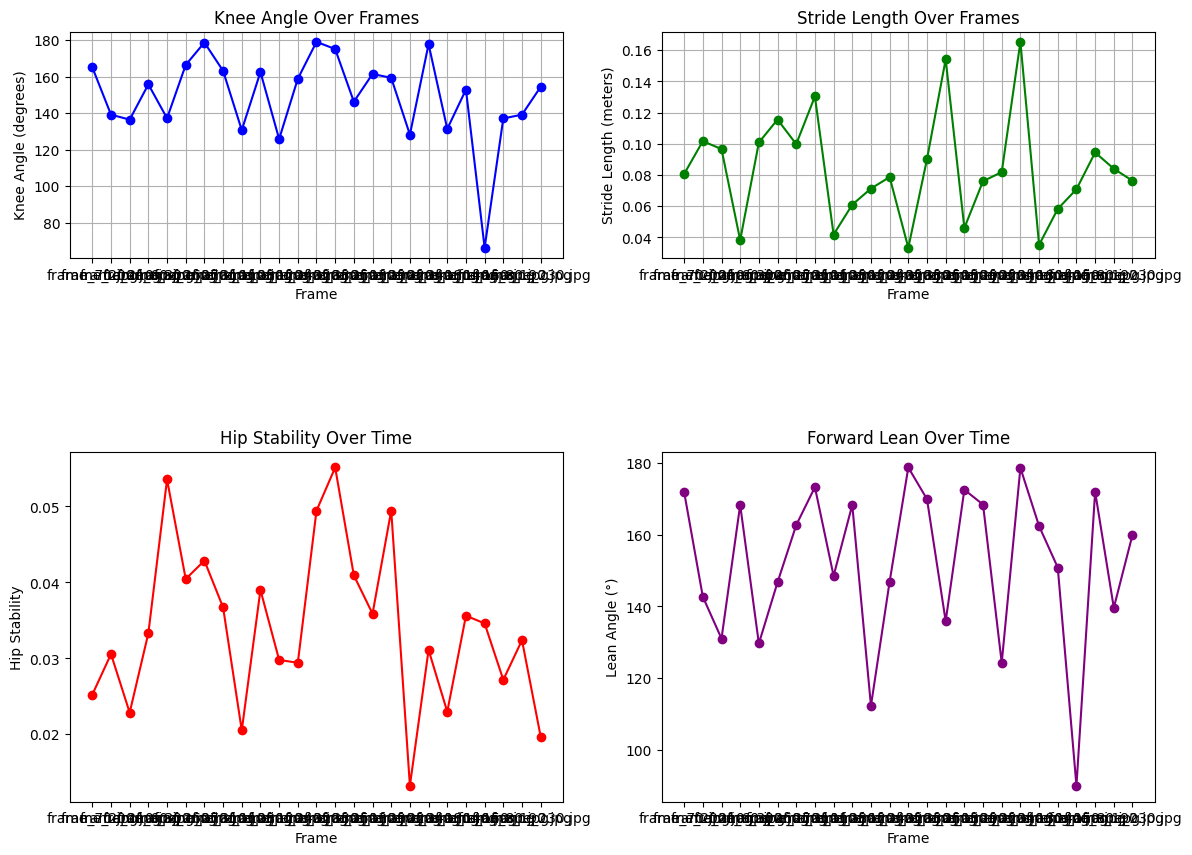

In [ ]:
def plot_skating_metrics(df, metrics):
    """
    Plot specified skating metrics over frames.

    Parameters:
    df (pd.DataFrame): DataFrame containing skating metrics.
    metrics (list): List of metrics to plot (e.g., ['Knee_Angle', 'Stride_Length']).
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10))
    num_metrics = len(metrics)
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot((num_metrics + 1) // 2, 2, i)
        plt.plot(df["Frame"], df[metric], marker='o')
        plt.title(f'{metric.replace("_", " ")} Over Frames')
        plt.xlabel('Frame')
        plt.ylabel(metric.replace("_", " "))
        plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
metrics_to_plot = ['Knee_Angle', 'Stride_Length', 'Hip_Stability', 'Lean_Angle']
plot_skating_metrics(df, metrics_to_plot)


In [4]:
# Load NHL Interviews
# NB --> improvements: (1) add a file_age condition, (2) add a boolean y/n refresh, (3) turn this into general function for any dataset

# 📂 File path for the saved dataset (in a sibling folder)
file_path = "../data/all_nhl_interviews_5pages.csv"

# 🌐 URL for the NHL interviews + maximum sub-pages on main URL to scan
main_url = "https://mapleleafshotstove.com/leafs-news/game-day"
max_pages = 5

#load NHL interview data from API if file doesn't exist / not saved already
if os.path.exists(file_path):
    print("📂 Teams CSV file found! Loading from saved file...")
    df_interviews = pd.read_csv(file_path)
else:
    print("🌍 Teams CSV file not found. Fetching data from API...")
    df_interviews = scrape_multiple_interviews(main_url, max_pages)
    df_interviews.to_csv(file_path, index=False)  # Save for future use

#verify
checkDataset(df_interviews)

NameError: name 'os' is not defined

In [ ]:
printFunctions()

📌 Functions Defined in Notebook:
get_rag_answer
get_bm25_answer
get_bm25_top_k_answers
print_memory_usage
list_variables
delete_variables
LossLogger
display_html_structure
find_html_tag
scrape_interview
find_interview_urls
scrape_multiple_interviews
clean_text
lemmatize_text
filter_photo_questions
filter_long_questions
plot_question_length_distribution
get_answer
get_best_answer_SBERT
calculate_exact_match_accuracy
mean_reciprocal_rank
mean_reciprocal_rank_SBERT
compute_accuracy
compute_mrr
evaluate_bm25
encode_text_dpr
get_dpr_answer
process_batches_dpr
evaluate_dpr
printFunctions
checkDataset
read_APIResponseStructure
show_memory_usage
delete_dataframe
optimize_dataframe
remove_hidden_variables


## **Section 4: Data Preprocessing & Feature Engineering** <a id="data_processing"></a>

In [ ]:
# Keep only the necessary columns - remove URL column as its not required for training
# remove rows with missing values
df_cleaned = df_interviews[['Question', 'Answer']].dropna() 

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  832 non-null    object
 1   Answer    832 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB


In [ ]:
# Filter out questions that start with "photo" (not relevant to interview questions)
df_cleaned = filter_photo_questions(df_cleaned)

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
Index: 826 entries, 0 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  826 non-null    object
 1   Answer    826 non-null    object
dtypes: object(2)
memory usage: 19.4+ KB


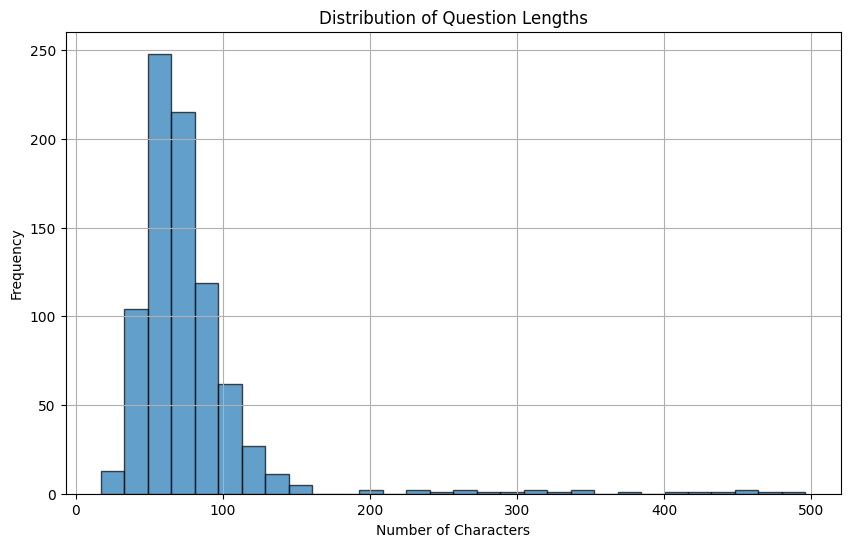

In [ ]:
# Plot the distribution of question lengths to determine the maximum length for filtering
plot_question_length_distribution(df_cleaned)

In [ ]:
# Filter out questions that are much longer than others
df_cleaned = filter_long_questions(df_cleaned, max_length=150)

checkDataset(df_cleaned)

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 1 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  802 non-null    object
 1   Answer    802 non-null    object
dtypes: object(2)
memory usage: 18.8+ KB


In [ ]:
# Create a copy of the original DataFrame before cleaning
# This will be used for displaying the original questions and answers
df_original = df_cleaned.copy()

checkDataset(df_original)

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 1 to 831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  802 non-null    object
 1   Answer    802 non-null    object
dtypes: object(2)
memory usage: 18.8+ KB


In [ ]:
# Apply cleaning to both question and answer columns
df_cleaned['Question'] = df_cleaned['Question'].apply(clean_text)
df_cleaned['Answer'] = df_cleaned['Answer'].apply(clean_text)

# Display the first few cleaned rows
print(df_cleaned.head())

                                            Question  \
1     rod brindamour on craig berubes coaching style   
2  craig berube on rod brindamours coaching succe...   
3  steven lorentz on his memories of playing for ...   
4  lorentz on the similarities between brindamour...   
5  berube on the challenge presented by the hurri...   

                                              Answer  
1  he never took a shift off and thats carried ov...  
2  he has done a great job here how he played as ...  
3  i learned a lot it was how i broke into the le...  
4  there are a lot actually and same with paul ma...  
5  theyve always been a tough opponent theyve bee...  


In [ ]:
# Remove stop words (common filler words) and apply lemmatization (standardize words to their base form)
df_cleaned['Question'] = df_cleaned['Question'].apply(lemmatize_text)
df_cleaned['Answer'] = df_cleaned['Answer'].apply(lemmatize_text)

# Display the first few cleaned rows
print(df_cleaned.head())

                                            Question  \
1        rod brindamour craig berubes coaching style   
2  craig berube rod brindamours coaching success ...   
3  steven lorentz memory playing brindamour carolina   
4  lorentz similarity brindamour berubes coaching...   
5               berube challenge presented hurricane   

                                              Answer  
1  never took shift thats carried coaching doesnt...  
2  done great job played player brought team work...  
3  learned lot broke league tremendous coach guy ...  
4  lot actually paul maurice last year play hard ...  
5  theyve always tough opponent theyve really goo...  


In [ ]:
# Split into 90% training and 10% testing
df_train, df_test = train_test_split(df_cleaned, test_size=0.1, random_state=42)

# Extract test questions and expected answers from the original DataFrame
test_questions = df_original.loc[df_test.index, 'Question'].tolist()
expected_answers = df_original.loc[df_test.index, 'Answer'].tolist()

print(f"Number of test questions: {len(test_questions)}")


Number of test questions: 81


In [ ]:
show_memory_usage()

df_interviews: 0.86 MB
df_cleaned: 0.31 MB
df_original: 0.73 MB
df_train: 0.25 MB
df_test: 0.03 MB


## **Section 5: Model 1 - Term Frequency-Inverse Document Frequency (TF-IDF)** <a id="logistic_model"></a>

### **Section 5a: Train a Model (TF-IDF)** <a id="tfidf_train"></a> ###

In [ ]:
# Using the TfidfVectorizer to convert text data to numerical vectors
# This is a common technique for text data in machine learning
# It converts text data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the question text data (on the training set)
# This step calculates the IDF values for each word in the corpus
# Fit_transform learns the vocabulary and transforms the text data into vectors
question_vectors = vectorizer.fit_transform(df_train['Question'])

### **Section 5b: Evaluate/Test a Model (TF-IDF)** <a id="tfidf_eval"></a> ###

In [ ]:
# Example of predicting an answer for a question using TF-IDF vectors
# The get_answer function uses cosine similarity to find the most similar question
# Then returns the answer to that question
input_question = "How did the team perform tonight?"
predicted_answer = get_answer(input_question)
print("Predicted Answer:", predicted_answer)

Predicted Answer: Opportunities are there. They hit some posts. They’ve missed the net a little bit. It is not clean as much at times, but overall, I am happy with the effort. They are working and doing the right things. The scoring will come.


In [ ]:
# Predict answers for the test questions
predicted_answers = [get_answer(q) for q in test_questions]

# Calculate the accuracy of predictions using exact match (i.e., the predicted answer matches the expected answer)
accuracy = calculate_exact_match_accuracy(expected_answers, predicted_answers)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.0


In [ ]:
# Compute MRR -- mean reciprocal rank
# Fuzzier evaluation by considering the rank of the correct answer in the list of predicted answers
# Higher MRR is better
mrr_score = mean_reciprocal_rank(test_questions, expected_answers)
print("Mean Reciprocal Rank (MRR):", mrr_score)


Mean Reciprocal Rank (MRR): 0.010799732287647985


**Step 5: Analyze the Results**
- **Accuracy > 70%:** Model is doing well.
- **Accuracy < 50%:** Model needs improvement (e.g., better cleaning, using embeddings instead of TF-IDF).
- **MRR > 0.7:** Correct answers appear in the top-2 results.
- **MRR < 0.4:** The model is struggling to rank answers correctly.

If both Exact Match = 100% and MRR = 1.0, it means (before we split test and training data):
- The model is retrieving perfect answers with no ranking errors.
- It’s likely overfitting or the dataset is too easy --> **test data was in the training data (previously)!**
- In real-world Q&A tasks, MRR is a better metric than Exact Match, since correct answers can be phrased differently.

If Exact Match and MRR are below 40%, 
|Issue	|Symptoms|	Solution|
|--|--|--|
|Poor text preprocessing|	Model treats "win" ≠ "winning" ≠ "victory"|	Improve text cleaning (lemmatization, stopwords)|
|Lack of understanding |	Model fails for paraphrased questions |	Use SBERT or BERT embeddings |
| Too small dataset |	Model retrieves random answers |	Expand dataset with more interview questions|
|Wrong similarity metric |	Model ranks irrelevant answers higher	| Tune TF-IDF parameters or switch to embeddings|
|Over-reliance on keywords |	Model struggles with reworded questions	|Use word embeddings instead of TF-IDF|

Update: I updated model to apply lemmatization and stop words.  Exact Match stayed at 0%.  MRR went up from 1.3 to 1.6%.  Still not significant enough.  This was with a dataset that had ~200 questions.  

The model accuracy got worse with ~800 records at 1% accuracy.

### **Section 5c: Fine-Tune the Model (TF-LDF)**  <a id="tfldf_finetune"></id>

In [ ]:
# Fine tune the TF-IDF vectorizer to improve the model performance
# TfidfVectorizer parameters:
# - stop_words: Remove common words
# - ngram_range: Include word pairs (bigrams, eg "power play")
# - max_df: Ignore words in 85%+ of documents (remove common words)
# - min_df: Ignore rare words appearing in <2 docs (remove uncommon words)
# - max_features: Limit the number of features (words) to consider
# - sublinear_tf: Apply sublinear TF scaling (replace TF with 1 + log(TF))
# - use_idf: Enable inverse document frequency (IDF) reweighting
# - smooth_idf: Smooth IDF weights by adding 1 to document frequencies
# - norm: Apply L2 normalization to feature vectors
# - binary: Convert non-zero feature values to 1 (binary representation)
# - token_pattern: Regular expression pattern for tokenizing words
# - tokenizer: Custom tokenizer function (if needed, eg to keep hockey-related terms)
# - preprocessor: Custom preprocessor function (if needed)
# - lowercase: Convert text to lowercase
# - encoding: Text encoding format
# - decode_error: Error handling during text decoding
# - strip_accents: Remove accents from characters
# - analyzer: Custom analyzer for extracting features
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common words
    ngram_range=(1, 2),  # Include word pairs (bigrams)
    max_df=0.85,  # Ignore words in 85%+ of documents
    min_df=2  # Ignore rare words appearing in <2 docs
)

question_vectors = vectorizer.fit_transform(df_train['Question'])


In [ ]:
# Predict answers for the test questions with fine-tuned vectorizer
predicted_answers = [get_answer(q) for q in test_questions]

# Calculate the accuracy of predictions using exact match (i.e., the predicted answer matches the expected answer)
accuracy = calculate_exact_match_accuracy(expected_answers, predicted_answers)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.0


In [ ]:
# Compute MRR -- mean reciprocal rank -- with fine-tuned vectorizer
# Fuzzier evaluation by considering the rank of the correct answer in the list of predicted answers
# Higher MRR is better
mrr_score = mean_reciprocal_rank(test_questions, expected_answers)
print("Mean Reciprocal Rank (MRR):", mrr_score)


Mean Reciprocal Rank (MRR): 0.011183230323748109


Changing the parameters **increased MRR from 1.6% to 3.4%** with ~200 record data set.

Model accuracy got worse with 800 records - 0.1%

## **Section 6: Model 2 - Sentence BERT** <a id="sbert_model"></a> ##

**What is SBERT?**
- Understands sentence meaning instead of just individual words.
- Handles reworded questions better than TF-IDF.
- Uses pre-trained deep learning models to generate vector representations.
- Works well even with small datasets.


**Why is it better than TF-IDF and BERT?**
|Feature	|TF-IDF|	BERT	|SBERT|
|---|---|---|---|
|Understands Word Meaning?	|❌ No (only counts words)|	✅ Yes (deep contextual understanding)|	✅ Yes (optimized for sentence similarity)|
|Handles Synonyms?	|❌ No|	✅ Yes|	✅ Yes|
|Handles Paraphrased Questions?	|❌ No|	✅ Yes|	✅ Yes|
|Computational Efficiency	|✅ Fast|	❌ Slow|	✅ Fast|
|Requires Large Training Data?	|❌ No|	✅ Yes (requires fine-tuning)|	✅ Yes (but works well out-of-the-box)|
|Handles Short Text Well?	|✅ Yes	|✅ Yes	|✅ Yes|
|Best for Q&A Retrieval?|	❌ No|	✅ Yes (but slow)|	✅ Yes (faster than BERT)|
|Best for Sentence Similarity?|	❌ No|	✅ Yes	|✅ Yes (optimized for this)|
|Pre-trained Model Available?|	❌ No (requires manual vectorization)	|✅ Yes	|✅ Yes|
|Example Use Cases|	Search engines, keyword matching|	Chatbots, language understanding, deep NLP tasks	|Chatbots, Q&A, semantic search, recommendation systems|

### **Section 6a: Prepare Data for SBERT Model** <a id="sbert_data"></a> ###

SBERT training works with looking at the relationship between sentences.  We will prepare dataset to have:
1. Question
2. Correct Answer
3. Negative Answer (a random other answer in the dataset)

The SBERT model will be trained to match question closer to the correct answer then the negative answer

In [ ]:
# Retrive interview dataset (cleaned) and ensure all text columns are strings
df_cleaned["Question"] = df_cleaned["Question"].astype(str)
df_cleaned["Answer"] = df_cleaned["Answer"].astype(str)

# Shuffle answers to generate negative samples
df_cleaned["Negative Answer"] = df_cleaned["Answer"].sample(frac=1, random_state=42).reset_index(drop=True)

# Remove cases where positive and negative answers are the same
df_cleaned = df_cleaned[df_cleaned["Answer"] != df_cleaned["Negative Answer"]]

# Ensure all values are string types before passing to InputExample
df_cleaned["Negative Answer"] = df_cleaned["Negative Answer"].astype(str)

In [ ]:
# Split into 80% training and 20% testing for training
df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=42)

In [ ]:
# Convert to InputExample format - data structure used in SBERT for training models
train_examples = [InputExample(texts=[row["Question"], row["Answer"], row["Negative Answer"]]) for _, row in df_train.iterrows()]
test_examples = [InputExample(texts=[row["Question"], row["Answer"], row["Negative Answer"]]) for _, row in df_test.iterrows()]


### **Section 6a: Use Pre-Trained SBERT Model - No Fine-Tuning** <a id="sbert_train"></a> ###

We will start by checking accuracy of pre-trained SBERT model without any fine-tuning using training data (i.e. domain-specific info related to NHL questions and answers).  In this case, we are just loading a model, and checking accuracy.

In [ ]:
# Check if MPS (Metal Performance Shaders) is available
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load SBERT model and move to correct device
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

Using device: mps


Why all-MiniLM-L6-v2?
- Fast & lightweight (smaller embedding size)
- Optimized for sentence similarity
- Good balance of accuracy vs speed

In [ ]:
# Compute accuracy
accuracy = compute_accuracy(model, df_test)
print(f"Model Accuracy: {accuracy:.4f}")

# Compute MRR
mrr_score = compute_mrr(model, df_test)
print(f"Model MRR: {mrr_score:.4f}")



Model Accuracy: 0.7453
Model MRR: 0.7727


### **Section 6c: Fine-Tune SBERT with Training Data** <a id="sbert_hyper"></a>

This time we will fine-tune pre-trained SBERT model with NHL interview training data and check impact on accuracy.

In [ ]:
# Define DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=1, pin_memory=False, num_workers=0)

# Define loss function: compares question vs. current answer vs. negative answer
train_loss = losses.TripletLoss(model)

# Initiate callback for logging losses during training process
loss_logger = LossLogger(log_interval=10)

# Train model with logging
try:
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,
        warmup_steps=100,
        max_grad_norm=0.5,  # Prevents gradient explosion
        show_progress_bar=True,
        callback=loss_logger  # Manually pass batch callback
    )
except Exception as e:
    import traceback
    print("Error:", e)
    traceback.print_exc()

Loss Logger Initiated!


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,4.910300


In [ ]:
# Compute accuracy
accuracy = compute_accuracy(model, df_test)
print(f"Model Accuracy: {accuracy:.4f}")

# Compute MRR
mrr_score = compute_mrr(model, df_test)
print(f"Model MRR: {mrr_score:.4f}")

Model Accuracy: 0.7516
Model MRR: 0.7481


The MRR dropped from 77% to 75% after fine-tuning (i.e. the pre-trained / generic SBERT model was better!).  Why? 

1. **Not Enough Training Data**
    1. SBERT is already pre-trained on a large, diverse dataset with general sentence relationships.
    2. If your NHL dataset is too small (~800 examples), the model may overfit to the small sample, losing generalization ability.
    3. *Fix:* 
        1. Try adding more training data (more interview Q&A pairs
        2. Consider data augmentation (e.g., paraphrasing questions and answers using NLP).
2. **Overfitting to Training Data**
    1. When fine-tuning, the model may have memorized the training data instead of learning general NHL interview patterns.
    2. This could cause it to perform well on training but poorly on test data.
    3. *Fix:*
        1. Use early stopping (stop training when validation loss stops improving).
        2. Regularization techniques:
            1. Reduce epochs (e.g., try 0.5-1 epoch instead of 2-3).
            2. Increase dropout rate (SBERT uses dropout layers to prevent overfitting).
3. **The Pre-Trained Model Was Already "Good Enough"**
    1. SBERT is trained on diverse sentence pairs, including question-answering datasets.
    2. Your NHL dataset may not be different enough from SBERT’s original training set, so fine-tuning doesn’t add much value and instead distorts the pre-trained weights.
    3. *Fix:*
        1. Instead of fine-tuning all layers, try only updating the last few layers (freeze=True for earlier layers).
        2. Use "adapter layers" (lightweight layers added to SBERT without overwriting pre-trained knowledge).
4. **Incorrect Training Setup**
    1. You used Triplet Loss, which forces the model to distinguish between:
        1. Question → Correct Answer (high similarity)
        2. Question → Negative Answer (low similarity)
    2. If your negative samples are too similar to the correct answers, the model may struggle.
    3. Fix:
        1. Make sure negative answers are truly incorrect (not semantically similar to correct answers).
        2. Experiment with other loss functions:
            1. MultipleNegativesRankingLoss (better for ranking tasks)
            2. ContrastiveLoss (may work better for answer retrieval)
5. Learning Rate May Be Too High
    1. If the learning rate is too high, the model may make big jumps, forgetting useful pre-trained knowledge.
    2. If it’s too low, the model may not learn anything meaningful.
    3. Fix:
        1. Try lowering the learning rate (1e-5 instead of 2e-5).
        2. Use slower warmup steps (e.g., increase warmup_steps from 100 to 200).

### **Section 6d: Optimize SBERT** <a id="sbert_optimize"></a>

Try to improve SBERT performance over baseline pre-trained model by:
1. Change loss function from TripletLoss to MultipleNegativesRankingLoss --> ranks correct answers higher than negative, makes training faster
2. Freeze earlier layers of neural net --> first layers already encode general sentence structure that the pre-trained SBERT does well.  We only wnat to fine-tune later layers with NHL-specific knowledge.
3. Lower learning rate --> if LR is too high, model may forget pre-trained knowledge (skips too quickly)
4. Add more training data with bigger training set OR by augmenting data (eg paraphrasing, synonyms)
5. Try larger pre-trained SBERT model (more parameters to understand meaning of interview data)

**Trial 1: Change Loss Function**

In [ ]:
# Re-load SBERT model and move to correct device
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

In [ ]:
# change loss function 
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
run_trial = False
# Re-train model
try:
    if(run_trial):
        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=1,
            warmup_steps=100,
            max_grad_norm=0.5,  # Prevents gradient explosion
            show_progress_bar=True,
            callback=loss_logger  # Manually pass batch callback
        )
    else:  
        print("Skipped model fit")
except Exception as e:
    print(f"Error: {e}")


Skipped model fit


In [ ]:
run_trial = False

if(run_trial):
    # Compute accuracy
    accuracy = compute_accuracy(model, df_test)
    print(f"Model Accuracy: {accuracy:.4f}")

    # Compute MRR
    mrr_score = compute_mrr(model, df_test)
    print(f"Model MRR: {mrr_score:.4f}")

**Trial 2: Freeze Earlier Layers**

Trial 1 (loss function) + Freeze layers 

In [ ]:
# Freeze the first 4 layers of the model - i.e. turn off SGD
for param in model[0].auto_model.encoder.layer[:4].parameters():
    param.requires_grad = False

In [ ]:
run_trial = False
# Re-train model
try:
    if(run_trial):
        model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=1,
            warmup_steps=100,
            max_grad_norm=0.5,  # Prevents gradient explosion
            show_progress_bar=True,
            callback=loss_logger  # Manually pass batch callback
        )
    else:
        print("Skipped model fine-tuning")
except Exception as e:
    print(f"Error: {e}")

Skipped model fine-tuning


In [ ]:
run_trial = False

if(run_trial):
    # Compute accuracy
    accuracy = compute_accuracy(model, df_test)
    print(f"Model Accuracy: {accuracy:.4f}")

    # Compute MRR
    mrr_score = compute_mrr(model, df_test)
    print(f"Model MRR: {mrr_score:.4f}")

**Trial 3: Lower Learning Rate**

Trial 1 & 2 + Lower Learning Rate (cumulative)

In [ ]:
run_trial = False
# Re-train model
if(run_trial):
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,  
        warmup_steps=200,  # Increased for smoother transition
        max_grad_norm=0.5,  
        optimizer_params={'lr': 1e-5},  # Lowered learning rate
        show_progress_bar=True
    )
else:
    print("Skipped model fine-tuning")

Skipped model fine-tuning


**Trial 4: More Training Data**

Trial 1/2/3 + more training data

In [ ]:
#re-load SBERT pre-trained model
base_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

In [ ]:
# Get more training data from API or CSV (if saved)

# 📂 File path for the saved dataset (in a sibling folder)
file_path = "../data/all_nhl_interviews_20pages.csv"

# 🌐 URL for the NHL interviews + maximum sub-pages on main URL to scan
main_url = "https://mapleleafshotstove.com/leafs-news/game-day"
max_pages = 20

#load NHL interview data from API if file doesn't exist / not saved already
if os.path.exists(file_path):
    print("📂 Teams CSV file found! Loading from saved file...")
    df_interviews_lg = pd.read_csv(file_path)
else:
    print("🌍 Teams CSV file not found. Fetching data from API...")
    df_interviews_lg = scrape_multiple_interviews(main_url, max_pages)
    df_interviews_lg.to_csv(file_path, index=False)  # Save for future use


📂 Teams CSV file found! Loading from saved file...


In [ ]:
checkDataset(df_interviews_lg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URL       2605 non-null   object
 1   Question  2597 non-null   object
 2   Answer    2605 non-null   object
dtypes: object(3)
memory usage: 61.2+ KB


In [ ]:
# Data pre-processing for training

# Keep only the necessary columns - remove URL column as its not required for training
# remove rows with missing values
df_cleaned_lg = df_interviews_lg[['Question', 'Answer']].dropna() 

# Filter out questions that start with "photo" (not relevant to interview questions)
df_cleaned_lg = filter_photo_questions(df_cleaned_lg)

# Filter out questions that are much longer than others
df_cleaned_lg = filter_long_questions(df_cleaned_lg, max_length=150)

# This will be used for displaying the original questions and answers
df_original_lg = df_cleaned_lg.copy()

# Apply cleaning to both question and answer columns
df_cleaned_lg['Question'] = df_cleaned_lg['Question'].apply(clean_text)
df_cleaned_lg['Answer'] = df_cleaned_lg['Answer'].apply(clean_text)

# Remove stop words (common filler words) and apply lemmatization (standardize words to their base form)
df_cleaned_lg['Question'] = df_cleaned_lg['Question'].apply(lemmatize_text)
df_cleaned_lg['Answer'] = df_cleaned_lg['Answer'].apply(lemmatize_text)

In [ ]:
# Prepare (Question, Correct Answer, Negative Answer) for training

# Retrive interview dataset (cleaned) and ensure all text columns are strings
df_cleaned_lg["Question"] = df_cleaned_lg["Question"].astype(str)
df_cleaned_lg["Answer"] = df_cleaned_lg["Answer"].astype(str)

# Shuffle answers to generate negative samples
df_cleaned_lg["Negative Answer"] = df_cleaned_lg["Answer"].sample(frac=1, random_state=42).reset_index(drop=True)

# Remove cases where positive and negative answers are the same
df_cleaned_lg = df_cleaned_lg[df_cleaned_lg["Answer"] != df_cleaned_lg["Negative Answer"]]

# Ensure all values are string types before passing to InputExample
df_cleaned_lg["Negative Answer"] = df_cleaned_lg["Negative Answer"].astype(str)

In [ ]:
# Split into 80% training and 20% testing for training
df_train_lg, df_test_lg = train_test_split(df_cleaned_lg, test_size=0.2, random_state=42)

In [ ]:
# Convert to InputExample format - data structure used in SBERT for training models
train_examples_lg = [InputExample(texts=[row["Question"], row["Answer"], row["Negative Answer"]]) for _, row in df_train_lg.iterrows()]
test_examples_lg = [InputExample(texts=[row["Question"], row["Answer"], row["Negative Answer"]]) for _, row in df_test_lg.iterrows()]


In [ ]:
# Freeze the first 4 layers of the model - i.e. turn off SGD
for param in base_model[0].auto_model.encoder.layer[:4].parameters():
    param.requires_grad = False

In [ ]:
# Define DataLoader
train_dataloader_lg = DataLoader(train_examples_lg, shuffle=True, batch_size=1, pin_memory=False, num_workers=0)

# Define loss function: compares question vs. current answer vs. negative answer
train_loss = losses.TripletLoss(base_model)

# Initiate callback for logging losses during training process
loss_logger = LossLogger(log_interval=10)

# Train model with logging
try:
    top_sbert_model = base_model.fit(
        train_objectives=[(train_dataloader_lg, train_loss)],
        epochs=1,
        warmup_steps=100,
        max_grad_norm=0.5,  # Prevents gradient explosion
        show_progress_bar=True,
        callback=loss_logger  # Manually pass batch callback
    )
except Exception as e:
    print(f"Error: {e}")


Loss Logger Initiated!


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,4.923100
1000,4.894000
1500,4.869100
2000,4.842300


In [ ]:
# Compute accuracy
accuracy = compute_accuracy(model, df_test)
print(f"Model Accuracy: {accuracy:.4f} for {df_train.shape[0]} size training data")

# Compute MRR
mrr_score = compute_mrr(model, df_test)
print(f"Model MRR: {mrr_score:.4f} for {df_train.shape[0]} size training data")

Model Accuracy: 0.7453 for 641 size training data
Model MRR: 0.7727 for 641 size training data


**Trial 5: Use a larger SBERT model**

"all-mpnet-base-v2" performs better for ranking tasks than "all-MiniLM-L6-v2".

Took up 25GB RAM and crashed on Apple M4 / MPS CPU.  The smaller model took up 15GB RAM and was OK.

In [ ]:
#load different (larger) SBERT pre-trained model
model = SentenceTransformer("all-mpnet-base-v2", device=device)

In [ ]:
# loss function 
train_loss = losses.MultipleNegativesRankingLoss(model)

run_trial = False
# Re-train model
if(run_trial):
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,  
        warmup_steps=200,  # Increased for smoother transition
        max_grad_norm=0.5,  
        optimizer_params={'lr': 1e-5},  # Lowered learning rate
        show_progress_bar=True
    )
else:
    print("Skipped model fine-tuning")

Skipped model fine-tuning


In [ ]:
run_trial = False

if(run_trial):
    # Compute accuracy
    accuracy = compute_accuracy(model, df_test)
    print(f"Model Accuracy: {accuracy:.4f} for {df_train.shape[0]} size training data")

    # Compute MRR
    mrr_score = compute_mrr(model, df_test)
    print(f"Model MRR: {mrr_score:.4f} for {df_train.shape[0]} size training data")

**Overall - training with more data and freezing lower layers (trial 2 and 4) improved accuracy.  Larger model can't run on my machine, and LR and loss functions impact were immaterial.**

**Use trial 4 model for deployment**

## **Section 7: Model 3 - BM25**<a id="bm25"></a>

**BM25 (Best Matching 25)**
- An improved TF-IDF with better term weighting and ranking for ranking relevant answers.
- Great for retrieval tasks when you have a large dataset.
- Implement with rank_bm25 from the rank_bm25 library.

In [ ]:
# Prepare data for BM25 model
# Splits each answer into a list of words basd on whitespace as default
# Result is a list of list of answers, where each inner list is the words/tokens of an answer
# Starts with large dataset (20 pages; n=2000); both training and test data because its looking at all answers to choose from
tokenized_answers = [answer.split() for answer in df_cleaned_lg["Answer"].tolist()]

In [ ]:
#Run BM25 model on the training data (answer tokens)
bm25 = BM25Okapi(tokenized_answers)

In [ ]:
# Compute BM25 accuracy on the test set
bm25_accuracy = evaluate_bm25(df_test_lg, bm25, df_cleaned_lg)
print(f"BM25 Test Accuracy: {bm25_accuracy:.4f}")

Question: granato knew matthew could handle toronto market enjoy huge success nhler
Predicted Answer: worked best possibly could worked going process didnt look team besides toronto knew door closed didnt much choice regard door soon door closed quickly looked edmonton said team place want wife got permission went visited right away knew spot key thing think grow family important hockeywise dream fit knew start would fit best would best chance win ultimately want win stanley cup opportunity play connor leon nuge dream scenario worked best possibly could
Correct Answer: really simple coach challenge player every day guy across ice colour jersey going challenge harder coach probably need play ahl auston around nhl didnt feel player going break confidence ended struggling certain night would want go back play player tell working want player fix right essence process happens guy enter league confident enough opponent across skill level high dynamic removed night lost confidence didnt play 

In [ ]:
# Test BM25
query = "What are the keys to the game?"
print(f"Question: {query}")
print("BM25 Answer:", get_bm25_answer(query, bm25))

Question: What are the keys to the game?
BM25 Answer: I think it is just experience. When he first came in, he was 18. He has learned a lot in the last couple of years. It hasn’t been easy for him with injuries and the way the world kind of shifted as he was entering the league. It is not easy mentally or physically going through that, but he has looked really confident so far. I think the biggest thing for him is that sometimes you try too hard and it almost works against you where you are trying, forcing, pushing, and wanting it so bad. Sometimes you just have to kind of relax out there and play your game — work hard, play smart, and don’t try to force the issue too much. I think in this camp he has done a really good job of finding his game. When you score a couple of goals, you get that confidence. That has been great to see.


In [ ]:
# Test BM25
query = "What are the keys to the game?"
top_k = 3
print(f"Question: {query}")
print("BM25 Answer:", get_bm25_top_k_answers(query, bm25, top_k))

Question: What are the keys to the game?
BM25 Answer: [2604    He moves pucks well. He has played in the leag...
863     Yeah, it was just a really awkward situation. ...
870     With Dermott and Engvall coming back in, those...
Name: Answer, dtype: object, 2604    He moves pucks well. He has played in the leag...
863     Yeah, it was just a really awkward situation. ...
870     With Dermott and Engvall coming back in, those...
Name: Answer, dtype: object, 2604    He moves pucks well. He has played in the leag...
863     Yeah, it was just a really awkward situation. ...
870     With Dermott and Engvall coming back in, those...
Name: Answer, dtype: object]


## **Section 8: Model 4 - Dense Passage Retrieval (DPR)**<a id="dpr"></a>

**DPR (Dense Passage Retrieval)**
- DPR encodes questions and answers into embeddings, using deep learning for better similarity ranking.
- Unlike TF-IDF or BM25, DPR uses deep learning embeddings for better retrieval.
- Pre-trained by Facebook AI on large datasets.
- Available via Hugging Face’s transformers library.

**Limitations**
- Pre-trained model we used (single-nq-base) has 512 character limit - most answers got cut off
- 

In [ ]:
# Load DPR models & tokenizers if they are not already loaded
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

In [ ]:
# Load dataset of answers
all_answers = df_cleaned_lg["Answer"].tolist()

# Define batch size for processing answers (to reduce memory load)
batch_size = 4

# Process answers in batches and get embeddings for each answer
answer_embeddings = process_batches_dpr(all_answers, batch_size, context_tokenizer, context_encoder)


In [ ]:
# Compute DPR accuracy on the test set
dpr_accuracy = evaluate_dpr(df_test, question_encoder, question_tokenizer, answer_embeddings, all_answers)
print(f"DPR Test Accuracy: {dpr_accuracy:.4f}")

DPR Test Accuracy: 0.0062


In [ ]:
# Test DPR search retrieval
query = "What is the key to the game?"
all_answers_orig = df_original_lg["Answer"]
print(f"Question: {query}")
print("DPR Answer:", get_dpr_answer(query, question_tokenizer, question_encoder, answer_embeddings, all_answers_orig))

Question: What is the key to the game?
DPR Answer: It is always a funny game, the last one before the break. It is just the reality of it. It is one of those things where you can’t help that you have plans after the game. You have family in, or you are trying to get out. You have all sorts of stuff that is happening. Our message today was really just about focusing on the fact that you have 60 minutes remaining to play. As good as things have gone for us of late —  the two-game losing streak on the road notwithstanding — we feel good about our game and want to go into the break with that same feeling.


## **Section 9: Model 5 - T5 (Generative)**<a id="T5"></a>

**T5 (Text-to-Text Transfer Transformer)**
- Instead of retrieving an answer, these models generate a new answer.
- Pre-trained for question answering and summarization.
- T5 can generate complete, human-like answers.
- Available via Hugging Face transformers.

**Limitations**
- t5-small appears to be used for translating from EN to FR only.  Otherwise, responses have been useless
- t5-flan appears to be able to answer more questions; still no NHL knowledge, and not robust

**Use cases**
|Task|Example Input Prompt	|Example Output|
|--|--|--|
|Summarization	|"summarize: The hockey team played a fast-paced game and secured a win."|	"The hockey team won."|
|Question Answering	|"question: What is the capital of Canada? answer:"	|"Ottawa"|
|Translation	|"translate English to French: I play hockey."	|"Je joue au hockey."|
|Text Completion	|"complete: The best way to win in hockey is to"	|"play as a team and move the puck."|
|Paraphrasing	|"paraphrase: Hockey is a fast-paced sport."|	"The sport of hockey is known for its speed."|
|Sentiment Analysis|	"sentiment analysis: I love playing hockey!"|	"Positive"|
|Grammar Correction	|"correct: She go to school every day."	|"She goes to school every day."|
|Code Generation	|"write python function to add two numbers."	|"def add(a, b): return a + b"|


In [ ]:
# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Generate an answer
def generate_answer_t5small(question):
    input_text = f"Respond in French: {question}"
    print(tokenizer.encode(input_text))
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_length=50, do_sample=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Example:
print(generate_answer_t5small("What is the best was to prepare for a game?"))


[23483, 16, 2379, 10, 363, 19, 8, 200, 47, 12, 2967, 21, 3, 9, 467, 58, 1]
Quelle era la meilleure manière d'ajuster à la question : Quel est le meilleur serait pour préparer le jeu?


In [ ]:
# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

# Generate an answer
def generate_answer_t5flan(question):
    input_text = f"question: {question} answer:"
    print(tokenizer.encode(input_text))
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_length=50, do_sample=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Example:
print(generate_answer_t5flan("What is the capital of USA?"))


[822, 10, 363, 19, 8, 1784, 13, 2312, 58, 1525, 10, 1]
elmerio


In [ ]:
# Load model and tokenizer
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")

# Generate an answer
def generate_answer_t5base(question):
    input_text = f"summarize: {question}"
    print(tokenizer_t5.encode(input_text))
    input_ids = tokenizer_t5(input_text, return_tensors="pt").input_ids
    output_ids = model_t5.generate(input_ids, max_length=50, do_sample=True)
    return tokenizer_t5.decode(output_ids[0], skip_special_tokens=True)

# Example:
question = "this is a really really really really really long sentence"
generated_response = generate_answer_t5base(question)
print(f"Question: {question}, Answer: {generated_response}")

[21603, 10, 48, 19, 3, 9, 310, 310, 310, 310, 310, 307, 7142, 1]
Question: this is a really really really really really long sentence, Answer: a really really really really really really really really really long sentence .


In [ ]:
# Fine-tune T5 model with NHL interview dataset
"""
training_args = TrainingArguments(
    output_dir="./t5_finetuned",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_train_lg,
    eval_dataset=df_test_lg,
)
trainer.train()
"""

## **Section 10: Model 6 - GPT-4 (Generative)**<a id="gpt4"></a>

Placeholder

In [ ]:
"""
openai.api_key = ""
def ask_gpt(question):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": question}]
    )
    return response["choices"][0]["message"]["content"]

# Test GPT-4
query = "What were the keys to the hockey game?"
print("GPT-4 Answer:", ask_gpt(query))
"""

## **Section 11: Model 7 - RAG (Hybrid)**<a id="rag"></a>

**RAG (Hybrid answer retrieval and generation)**
1. Retrieve top 3 most relevant answers using BM25 or DPR.
2. Pass retrieved answers as context to T5/GPT for final response.

**Limitations**


**Use cases**
- tailor general purpose generative models to domain knowledge by adding specific answers to prompt

In [ ]:
# Test RAG
query = "Who was the best player on the ice"
print("RAG Answer:", get_rag_answer(query, retrieval_method="bm25", generator="t5"))

Summarize: It is more of me trying to be the best player I possibly can day in and day out — not just on the ice but off the ice. I am in the best shape of my life right now. He and the strength guys have been on me this summer. I was here quite a bit for the summer trying to prepare for the season. I feel amazing. Sometimes, when I get sloppy or I am not at my best, he is going to let me know. That is the way a coach should be. You have to be at your best. That is the way I would put it. You have to be aware of where he is at and where everything is at on the ice. You have to give it your best. A lot of times, with him or any other great player, you need all five guys out there on the same page helping out. It is challenging, but it is fun at the same time. It is what you want to do: compete against the best in the world. Playing with him has been a big opportunity for me. We hang out off of the ice quite a bit. We build that chemistry off the ice and bring it on the ice. Playing with

## **Section 11: Save the Trained Model** <a id="save_model"></a>

Both **joblib** and **pickle** libraries are used to save and load Python objects (like machine learning models), but they work differently.

**Using joblib (Recommended for ML models)**
- import joblib
- joblib.dump(best_xgb_model, "model.pkl")  # Save
- model = joblib.load("model.pkl")  # Load

**Using pickle**
- import pickle
- with open("model.pkl", "wb") as f:
    - pickle.dump(best_xgb_model, f)
- with open("model.pkl", "rb") as f:
    - model = pickle.load(f)

**Summary: joblib.dump() vs. pickle.dump()**
|Scenario|	Use joblib?|	Use pickle?|
|--|--|--|
|Saving ML models (XGBoost, Scikit-learn)?|	✅ Yes|	❌ No|
|Saving general Python objects?	|❌ No|	✅ Yes|
|Storing large NumPy arrays?|	✅ Yes|	❌ No|
|Need speed & efficiency?	|✅ Yes|	❌ No|




In [ ]:
# pickle library saves the trained model 
# it serializes the model object into a binary format and writes it into a pkl file
# later, we'll read and load the file for use in an app

with open("xgboost_model.pkl", "wb") as model_file:
    pickle.dump(best_xgb_model, model_file)


In [ ]:
# we also need to save how the model is scaling input data so we can apply the same method in the application
#If your app (eg Flask API) does not scale the input data the same way as during training, predictions will be off.

# Check how your model was trained (re-do from Section 5c)
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Save the scaler for API use
joblib.dump(scaler, "scaler.pkl")